In [1]:
%pip install geopandas

### **All imports needed to run the program:**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gdp
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import base64
import keras

from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, MaxPooling1D, Conv1D, Embedding, Input, GlobalAveragePooling1D

import warnings
warnings.filterwarnings('ignore')

In [3]:
# log into your google account & choose the select all options for access
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/Group2FinalProject/scrubbed.csv'
map_ca = '/content/drive/Shared drives/Group2FinalProject/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'

Mounted at /content/drive


### **Question 1**

When will the next UFO sighting be in California?

### **Upload the dataset and extract the relevant column (datetime):**
We are only predicting the next UFO sightings in California, so we only need the rows that have 'ca' in their `state` column. Also, we don't need all other columns except for `datetime` to make this prediction.

In [4]:
df = pd.read_csv(data_path)

# List of columns to drop
columns_to_drop = ['comments', 'city', 'date posted', 'shape', 'duration (seconds)', 'duration (hours/min)', 'country', 'state', 'latitude', 'longitude ']

# Filter for rows where 'state' is 'ca' and 'country' is 'us', and drop specified columns and cities
df_filtered = df[(df['state'] == 'ca') & (df['country'] == 'us')].drop(columns=columns_to_drop, axis=1)

### **Separate ``datetime`` column into two columns ``Date`` and ``Time``:**
We are not predicting the exact time of occurence, and therefore we don't need the timing information. However, because the dataset has both date and time together in one column, we want to separate the two and keep the `Date` column only.


In [5]:
df_filtered[['Date', 'Time']] = df_filtered['datetime'].str.split(' ', n=1, expand=True)
data = df_filtered.drop(columns=['datetime', 'Time'])

# Display the filtered DataFrame
display(data)

,Date
10,10/10/1968
30,10/10/1979
45,10/10/1989
63,10/10/1995
72,10/10/1998
...,...
80299,9/9/2012
80305,9/9/2012
80310,9/9/2012
80316,9/9/2013


### **Add extra information to set up for prediction:**
Here we add an extra column named `Observed` which shows whether a sighting was observed on the corresponding date. Since we only have the dates of UFO sightings observed, we want to fill the dates in between occurences with 0s to indicate no observations.

In [6]:
# Convert the current date format MM/DD/YYY to YYYY-MM-DD
data['Date'] = pd.to_datetime(data['Date'])
# Add an additional column
data['Observed'] = 1
# Remove duplicate dates as we don't need them
data = data[~data['Date'].duplicated()]
# Sort the dates from earliest to latest and fill the rows in between observed dates with 0
r = pd.date_range(start=data['Date'].min(), end=data['Date'].max())
data = data.set_index('Date').reindex(r).fillna(0.0).rename_axis('Date').reset_index()

display(data)

,Date,Observed
0,1937-08-15,1.0
1,1937-08-16,0.0
2,1937-08-17,0.0
3,1937-08-18,0.0
4,1937-08-19,0.0
...,...,...
28020,2014-05-03,1.0
28021,2014-05-04,1.0
28022,2014-05-05,1.0
28023,2014-05-06,0.0


### **Feature engineering:**
Prediction of next release dates heavily relies on feature engineering because we do not have any features besides the date itself. Therefore, we add extra columns to feed more information about the dates into our model.

In [7]:
# Extract/create more information about the dates
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
# The number of business day corresponding to the date (1st business day starts from 0)
# for example, 05/07/2014 was the 5th business day of that month, so it's shown as 4 in the chart
data['Workday_N'] = np.busday_count(
                    data['Date'].values.astype('datetime64[M]'),
                    data['Date'].values.astype('datetime64[D]'))
# Which day of the week that day was (0 to 6 for Monday to Sunday)
# for example, 08/15/1937 was Sunday, so it's shown as 6 in the chart
data['Week_day'] = data['Date'].dt.weekday
# Which week of the month that month was
# for example, the week of 08/16/1937 was the 4th week of that month
data['Week_of_month'] = (data['Date'].dt.day
                         - data['Date'].dt.weekday - 2) // 7 + 2
data['Weekday_order'] = (data['Date'].dt.day + 6) // 7
# Set the 'Date' itself as the index for better readability
data = data.set_index('Date')
display(data)

,Observed,Month,Day,Workday_N,Week_day,Week_of_month,Weekday_order
Date,,,,,,,
1937-08-15,1.0,8,15,10,6,3,3
1937-08-16,0.0,8,16,10,0,4,3
1937-08-17,0.0,8,17,11,1,4,3
1937-08-18,0.0,8,18,12,2,4,3
1937-08-19,0.0,8,19,13,3,4,3
...,...,...,...,...,...,...,...
2014-05-03,1.0,5,3,2,5,1,1
2014-05-04,1.0,5,4,2,6,1,1
2014-05-05,1.0,5,5,2,0,2,1


### **Train and test split:**
Split the preprocessed dataset with a ratio of 70:30 with the ``Observed`` column values as the target variables.

In [8]:
x = data.drop(['Observed'], axis=1)
y = data['Observed']  # Target variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### **Train and test the data:**
We used *RandomForestClassifier* because this model often results in higher accuracy compared to individual decision trees, as it reduces overfitting and variance. This is because it builds multiple trees and averages their predictions, which helps generalize well to unseen data.

But first, we do GridSearch for the best parameters to get high accuracy.

In [9]:
# GridSearch parameters:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model definition:
model = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_
# Predict using the best model
rf_pred = best_model.predict(x_test)
# Print classification report
print(classification_report(y_test, rf_pred))

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      7001
         1.0       0.55      0.04      0.07      1407

    accuracy                           0.83      8408
   macro avg       0.69      0.52      0.49      8408
weighted avg       0.79      0.83      0.77      8408



**Confusion matrix on the training result:**

In [10]:

rf_matrix = metrics.confusion_matrix(rf_pred, y_test)
tn, fp, fn, tp = rf_matrix.ravel()
print(f"\nConfusion Matrix:")
print(rf_matrix)
print(f"\nTP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")


Confusion Matrix:
[[6956 1352]
 [  45   55]]

TP: 55
TN: 6956
FP: 1352
FN: 45


### **Another model:**

Our instructor Pu recommended, we looked into implementing a Long-Short Term Memory (LSTM) model for our prediction task since we were doing a time projection. LSTM is useful and efficient for time-series data and temporally dependent data. We proposed that since we have historical dates available, we might be able to treat these dates as dependencies for the purposes of predicting the future. Thus, LSTM would help us learn these dependencies similarly to a Random Forest Classifier (RFC) would. However, this model resulted in a testing accuracy of ~83% which is close to that of RFC. We proceeded to use RFC for the future date prediction part because LSTM was more complex and overly variable (customizable layers led us to experiment with multiple different architectures and more sets of parameters).

In [11]:
# Reshape x_train and x_test to add a third dimension (LSTM layer expects a 3D array as input)
x_train_reshaped = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_reshaped = x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build a model with 1D convolutional and LSTM layers
# Sequential() reference: https://keras.io/guides/sequential_model/
# Conv1D reference: https://keras.io/api/layers/convolution_layers/convolution1d/
# LSTM reference: https://keras.io/api/layers/recurrent_layers/lstm/
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))    # input_shape is (n_features, # of items to process at a time)
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
sgd = keras.optimizers.SGD(0.002, 0.9, False)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
# Create tuple objects from the test sets as the validation data
val_data = (x_test_reshaped, y_test)

# Fit the model
history = model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=val_data, verbose=0)
# Predict the classes
y_pred = model.predict(x_test_reshaped).astype(int)   # classification metrics takes in integer type data

# Evaluate the model performance
scores = model.evaluate(x_test_reshaped, y_test, verbose=0)
print(f'Accuracy: {scores[1]*100:.2f}%')

print("Classification Report:")
print(classification_report(y_test, y_pred))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 8481 (33.13 KB)
Trainable params: 8481 (33.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

As mentioned earlier, the classification metrics are very similar to RFC. Since both models had similar performances, we proceeded to predict future sightings using RFC due to its simplicity.

### **Predict future date:**
We now create DataFrame with future dates for prediction and use our trained RandomForest model to predict future UFO sightings for one year ahead.

In [12]:
x_predict = pd.DataFrame(pd.date_range(date.today(), (date.today() +
            relativedelta(years=1)),freq='d'), columns=['Date'])

x_predict['Month'] = x_predict['Date'].dt.month
x_predict['Day'] = x_predict['Date'].dt.day
x_predict['Workday_N'] = np.busday_count(
                x_predict['Date'].values.astype('datetime64[M]'),
                x_predict['Date'].values.astype('datetime64[D]'))
x_predict['Week_day'] = x_predict['Date'].dt.weekday
x_predict['Week_of_month'] = (x_predict['Date'].dt.day -
                              x_predict['Date'].dt.weekday - 2)//7+2
x_predict['Weekday_order'] = (x_predict['Date'].dt.day + 6) // 7

x_predict = x_predict.set_index('Date')
prediction = best_model.predict(x_predict)
prediction = pd.DataFrame(prediction, columns=['Prediction'])
prediction['Date'] = x_predict.index

next_sightings = prediction[prediction['Prediction'] == 1]
next_sightings = next_sightings.reset_index()
next_sightings = next_sightings.drop(columns=['index'])
display(next_sightings)

,Prediction,Date
0,1.0,2024-06-01
1,1.0,2024-06-15
2,1.0,2024-06-30
3,1.0,2024-07-01
4,1.0,2024-07-15


### **Question 2**

Where in California will the next UFO sighting be?

### **Load the Data & Filter for California Datapoints**

In [13]:
ufo = df
ufo.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


We are only predicting the next UFO sightings in California, so we only need the rows that have 'ca' in their `state` column.

In [14]:
# Filter for datapoints for California sightings
ufo = ufo[(ufo['state'] == 'ca') & (ufo['country'] == 'us')]
# Drop Nan
ufo.dropna(inplace=True)
# Rename columns for clarity
ufo = ufo.rename(columns = {'duration (seconds)': 'duration_second',
    'date posted': 'date_posted', 'longitude ': 'longitude'})

### **Feature Engineering**

From the `datetime` feature, we will extract the minute, hour, day, month, and year to create separate columns containing these values

In [15]:
# Split Datetime into New Columns
ufo['datetime'] = pd.to_datetime(ufo['datetime'], errors='coerce')
ufo.replace([np.inf, -np.inf], np.nan, inplace=True)
ufo.dropna(inplace=True)

ufo['datetime_month'] = ufo['datetime'].dt.month.astype(int)
ufo['datetime_day'] = ufo['datetime'].dt.day.astype(int)
ufo['datetime_year'] = ufo['datetime'].dt.year.astype(int)
ufo['datetime_hour'] = ufo['datetime'].dt.hour.astype(int)
ufo['datetime_min'] = ufo['datetime'].dt.minute.astype(int)

### **Remove Columns Not Used**

In [16]:
# Drop the original 'datetime', 'date_posted', 'comments', 'duration (hours/min)' columns
ufo = ufo.drop(columns=['datetime','date_posted','comments','duration (hours/min)', 'state', 'country'], axis=1)

### **Reducing Shape Column Complexity**

In order to make our model more generalizable, we decided to group together shapes based on similar descriptions to reduce the number of categories from 23 to 11

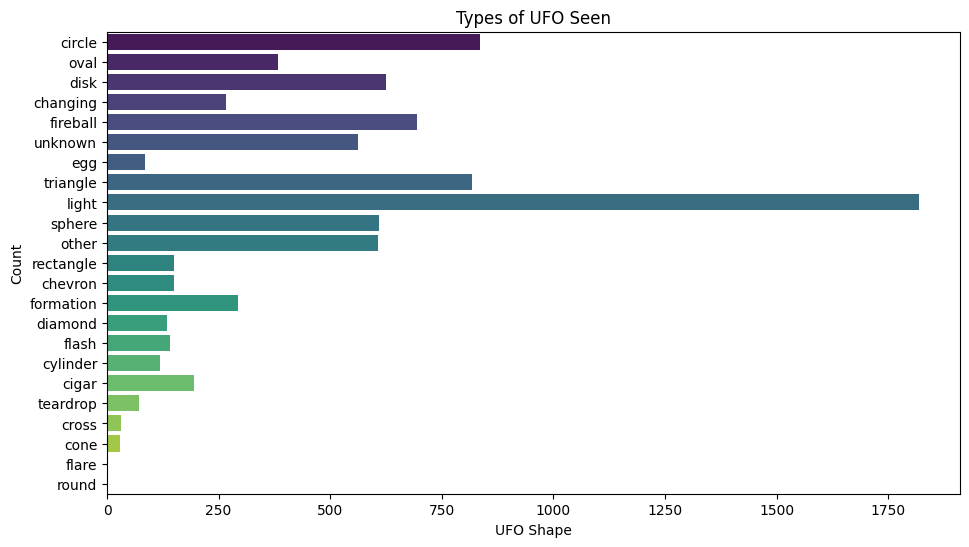

In [17]:
#Visualizing the most frequently observed UFO shape
plt.figure(figsize=(11, 6))
sns.countplot(y='shape', data=ufo, palette='viridis')
plt.xlabel('UFO Shape')
plt.ylabel('Count')
plt.title('Types of UFO Seen')
plt.show()

In [18]:
# Reduce Shape Complexity By Grouping Values
print(ufo['shape'].unique())
shape = {
    'round': ['circle', 'disk', 'sphere', 'round'],
    'oval': ['egg', 'oval'],
    'triangular': ['triangle', 'cone'],
    'rectangular': ['rectangle', 'diamond'],
    'light': ['light', 'flash', 'flare'],
    'teardrop': ['teardrop', 'fireball'],
    'cylindrical': ['cylinder', 'cigar'],
    'cross': ['cross'],
    'chevron': ['chevron'],
    'other': ['other', 'unknown'],
    'other2':['formation', 'changing']
}

for ufo_shape, ali in shape.items():
    ufo.loc[ufo['shape'].isin(ali), 'ufo_shape'] = ufo_shape

#Drop original column
ufo.drop(columns=['shape'], inplace=True)
ufo.head()

['circle' 'oval' 'disk' 'changing' 'fireball' 'unknown' 'egg' 'triangle'
 'light' 'sphere' 'other' 'rectangle' 'chevron' 'formation' 'diamond'
 'flash' 'cylinder' 'cigar' 'teardrop' 'cross' 'cone' 'flare' 'round']


,city,duration_second,latitude,longitude,datetime_month,datetime_day,datetime_year,datetime_hour,datetime_min,ufo_shape
10,hawthorne,300,33.9163889,-118.351667,10,10,1968,13,0,round
30,san diego,180,32.7152778,-117.156389,10,10,1979,22,0,oval
45,calabasas,300,34.1577778,-118.637500,10,10,1989,0,0,round
72,hollywood,300,34.0983333,-118.325833,10,10,1998,2,30,other2
82,martinez,3600,38.0194444,-122.133056,10,10,1999,0,1,other2


### **Visualizing Features**

In [19]:
#Convert type columns from object to float
ufo['latitude'] = ufo['latitude'].astype('float64')
ufo['duration_second'] = ufo['duration_second'].astype('float64')

#Create list with columns dtype object
object_col = [x for x in ufo.columns if ufo[x].dtype == 'object']

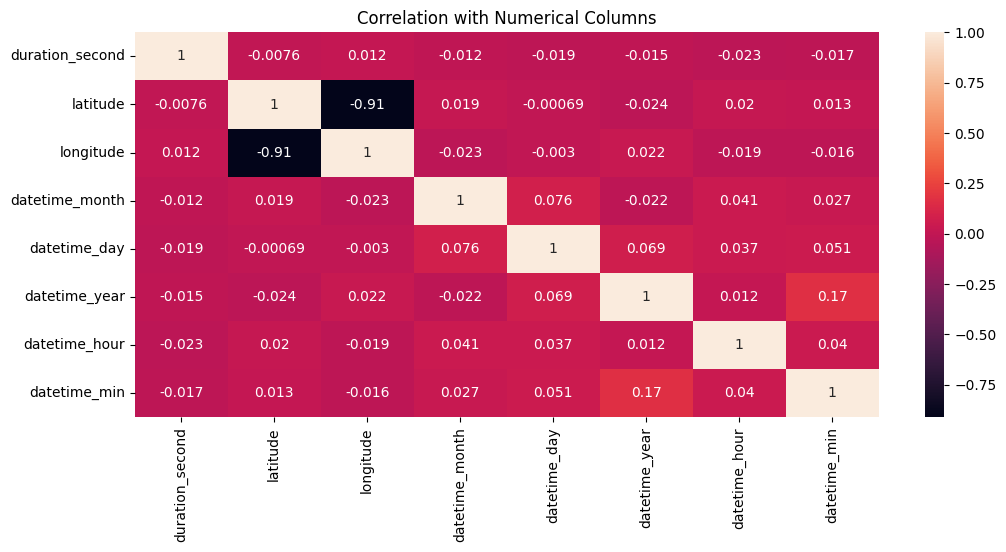

In [20]:
# Correlation columns
plt.figure(figsize=(12, 5))
sns.heatmap(ufo.select_dtypes(include=['int64', 'float64']).corr(), annot=True)
plt.title('Correlation with Numerical Columns')
plt.show()

From our heatmap, we can see that the new features added from the `datetime` are slightly correlated.

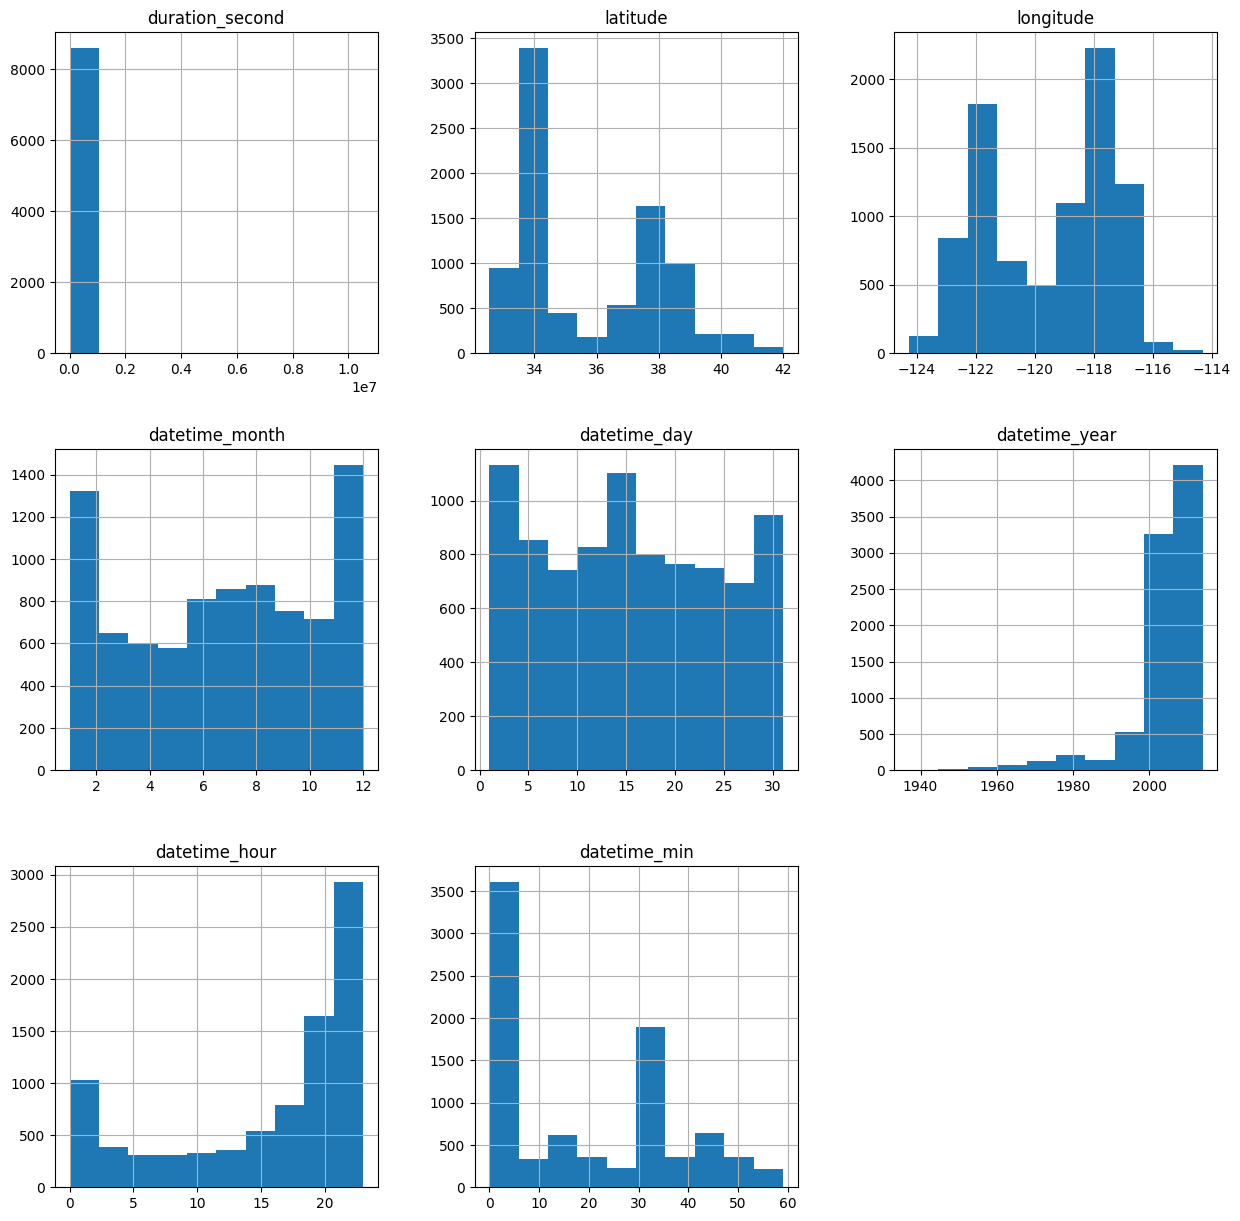

In [21]:
#Plot histograms of columns
ufo.hist(figsize=(15, 15))
plt.show()

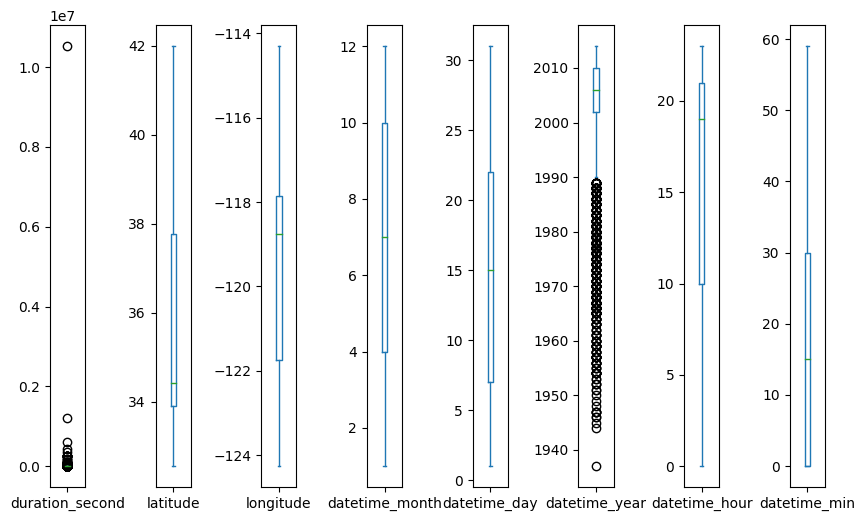

In [22]:
hold = ufo.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize=(10, 6)
)

# increase spacing between subplots
plt.subplots_adjust(wspace=2)
plt.show()

We felt that including datapoints deemed outliers from the standard cutoffs in our training and testing set would be beneficial due to the entire dataset being based on a subjective ufo sighting events, so separating between outliers and non-outliers would be difficult.  

### **Encoding Columns**

We chose to represent the categorical data as numerical values due to our targets being numerical and therefore we would be using a regression model.

In [23]:
# Encoding Object Columns
ufo_temp = ufo.copy()
object_columns = list(ufo_temp.select_dtypes(include='object'))
le = LabelEncoder()
for col in object_columns:
  ufo_temp[col] = le.fit_transform(ufo_temp[col])
ufo_temp.head()

,city,duration_second,latitude,longitude,datetime_month,datetime_day,datetime_year,datetime_hour,datetime_min,ufo_shape
10,419,300.0,33.916389,-118.351667,10,10,1968,13,0,8
30,909,180.0,32.715278,-117.156389,10,10,1979,22,0,6
45,146,300.0,34.157778,-118.637500,10,10,1989,0,0,8
72,442,300.0,34.098333,-118.325833,10,10,1998,2,30,5
82,627,3600.0,38.019444,-122.133056,10,10,1999,0,1,5


### **Split Data into Training & Testing sets**

In [24]:
X = ufo_temp.drop(columns=['latitude', 'longitude'], axis=1)
y_latitude = ufo_temp['latitude']
y_longitude = ufo_temp['longitude']

In [25]:
# Split the dataset into training and testing sets
X_train, X_test, y_train_latitude, y_test_latitude, y_train_longitude, y_test_longitude = train_test_split(X, y_latitude, y_longitude, test_size=0.2, random_state=42)
mms = MinMaxScaler()
X = mms.fit_transform(X)

### **Model 1: Gradient Boosting Regressor**

In [26]:
# Train the models
gb_latitude = GradientBoostingRegressor()
gb_latitude.fit(X_train, y_train_latitude)

gb_longitude = GradientBoostingRegressor()
gb_longitude.fit(X_train, y_train_longitude)

# Make predictions
y_pred_latitude_hgb = gb_latitude.predict(X_test)
y_pred_longitude_hgb = gb_longitude.predict(X_test)

In [27]:
# Cross Validation
cv_results = cross_val_score(gb_latitude, X_train, y_train_latitude, cv=5, scoring='r2')
print("Latitude Cross Validation Scores: ", cv_results)
print("Average CV Score: ", cv_results.mean())
cv_results = cross_val_score(gb_longitude, X_train, y_train_longitude, cv=5, scoring='r2')
print("Longitude Cross Validation Scores: ", cv_results)
print("Average CV Score: ", cv_results.mean())

Latitude Cross Validation Scores:  [0.39428377 0.39054789 0.39236154 0.39766957 0.38220863]
Average CV Score:  0.3914142795447895
Longitude Cross Validation Scores:  [0.38254856 0.37347279 0.38081734 0.37685982 0.36386869]
Average CV Score:  0.3755134379270895


### **Model 2: Histogram Gradient Boosting Regressor**

In [28]:
# Train the models
hgb_latitude = HistGradientBoostingRegressor()
hgb_latitude.fit(X_train, y_train_latitude)

hgb_longitude = HistGradientBoostingRegressor()
hgb_longitude.fit(X_train, y_train_longitude)

# Make predictions
y_pred_latitude_hgb = hgb_latitude.predict(X_test)
y_pred_longitude_hgb = hgb_longitude.predict(X_test)

In [29]:
# Cross Validation
cv_results = cross_val_score(hgb_latitude, X_train, y_train_latitude, cv=5, scoring='r2')
print("Latitude Cross Validation Scores: ", cv_results)
print("Average CV Score: ", cv_results.mean())
cv_results = cross_val_score(hgb_longitude, X_train, y_train_longitude, cv=5, scoring='r2')
print("Longitude Cross Validation Scores: ", cv_results)
print("Average CV Score: ", cv_results.mean())

Latitude Cross Validation Scores:  [0.45852715 0.47652617 0.43843809 0.43980178 0.43352661]
Average CV Score:  0.44936395888182157
Longitude Cross Validation Scores:  [0.45594345 0.46729652 0.4336865  0.437056   0.42942455]
Average CV Score:  0.44468140450896876


### **Model 3: Random Forest Regressor**

In [30]:
rf_latitude = RandomForestRegressor()
rf_latitude.fit(X_train, y_train_latitude)

rf_longitude = RandomForestRegressor()
rf_longitude.fit(X_train, y_train_longitude)

# Make predictions
y_pred_latitude_rf = rf_latitude.predict(X_test)
y_pred_longitude_rf = rf_longitude.predict(X_test)

In [31]:
# Cross Validation
cv_results = cross_val_score(rf_latitude, X_train, y_train_latitude, cv=5, scoring='r2')
print("Latitude Cross Validation Scores: ", cv_results)
print("Average CV Score: ", cv_results.mean())
cv_results = cross_val_score(rf_longitude, X_train, y_train_longitude, cv=5, scoring='r2')
print("Longitude Cross Validation Scores: ", cv_results)
print("Average CV Score: ", cv_results.mean())

Latitude Cross Validation Scores:  [0.7507889  0.7476158  0.75799633 0.72890209 0.73507783]
Average CV Score:  0.7440761918925209
Longitude Cross Validation Scores:  [0.75309506 0.77565268 0.7951506  0.76952698 0.75356242]
Average CV Score:  0.7693975500009198


After reviewing the cross validation scores from each model, we chose model 3, the random forest regressor, as our final model for question 2.

In [ ]:
# Evaluate the performance
r2_latitude_rf = r2_score(y_test_latitude, y_pred_latitude_rf)
r2_longitude_rf = r2_score(y_test_longitude, y_pred_longitude_rf)

print(f"r2_score latitude: {r2_latitude_rf}\n")
print(f"r2_score longitude: {r2_longitude_rf}")

### **Optimizing Parameters**

In [ ]:
param_grid = {
    'n_estimators': [100, 225, 350],
    'max_features': ['sqrt', 'log2', None],
}

# Create a random forest classifier
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions=param_grid)

# Fit the random search object to the data
rand_search.fit(X_train, y_train_latitude)

# Create a variable for the best model
best_rf1 = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

y_pred = best_rf1.predict(X_test)
r2 = r2_score(y_test_latitude, y_pred)
print("r2 latitude:", r2)

# Fit the random search object to the data
rand_search.fit(X_train, y_train_longitude)

# Create a variable for the best model
best_rf2 = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

y_pred = best_rf2.predict(X_test)
r2 = r2_score(y_test_longitude, y_pred)
print("r2 longitude:", r2)

Best hyperparameters: {'n_estimators': 350, 'max_features': None}
r2 latitude: 0.7937476102066989


In [ ]:
# Cross Validation
cv_resultsLat = cross_val_score(best_rf1, X_train, y_train_latitude, cv=5, scoring='r2')
print("Latitude Cross Validation Scores: ", cv_resultsLat)
print("Average CV Score: ", cv_resultsLat.mean())
cv_resultsLong = cross_val_score(best_rf2, X_train, y_train_longitude, cv=5, scoring='r2')
print("Longitude Cross Validation Scores: ", cv_resultsLong)
print("Average CV Score: ", cv_resultsLong.mean())

### **Prediction Results**

In [ ]:
df_pred_lat = pd.DataFrame({'predict_latitude_reg': y_pred_latitude_rf})
df_pred_lon = pd.DataFrame({'predict_longitude_reg': y_pred_longitude_rf})

ufo_temp['predict_latitude_ufo'] = df_pred_lat['predict_latitude_reg']
ufo_temp['predict_longitude_ufo'] = df_pred_lon['predict_longitude_reg']

In [ ]:
plt.style.use('dark_background')
states = gdp.read_file(map_ca)
states[states['NAME'] == 'California'].plot(figsize=(12, 12),color='#DFEEDA')
#plt.figure(figsize=(14, 8))
plt.scatter(ufo_temp['longitude'], ufo_temp['latitude'], color='pink', label='Real Data', s=3)
mask = ~ufo_temp['predict_latitude_ufo'].isnull() & ~ufo_temp['predict_longitude_ufo'].isnull()
plt.scatter(ufo_temp.loc[mask, 'predict_longitude_ufo'], ufo_temp.loc[mask, 'predict_latitude_ufo'], color='blue', label='Predictions', s=3)
plt.title('Real UFO Data vs Predictions', fontsize='18')
plt.xlabel('Longitude', fontsize='15')
plt.ylabel('Latitude', fontsize='15')
plt.xlim(-125, -113)
plt.ylim(32, 43)
plt.legend(fontsize="15",markerscale=3)
plt.show()